In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve, log_loss


#import os
#os.chdir('/Users/stephenrivas/Downloads')


In [2]:
dfTrue = pd.read_csv('True.csv')

In [3]:
#adding a column to the true csv file and setting it = to 1 for all rows
dfTrue['True/Fake'] = 1

In [4]:
dfFake = pd.read_csv('Fake.csv')

In [5]:
#adding a column to the fake csv file and setting it = to 0 for all rows
dfFake['True/Fake'] = 0

In [6]:
#combining the csv files
df_combined = pd.concat([dfTrue, dfFake], ignore_index=True)

In [7]:
#saving to csv
df_combined.to_csv('Combined_True_Fake.csv', index=False)

In [8]:
df_combined.columns

Index(['title', 'text', 'subject', 'date', 'True/Fake'], dtype='object')

In [9]:
df_combined.shape

(44898, 5)

In [10]:
df_combined.isnull().sum()

title        0
text         0
subject      0
date         0
True/Fake    0
dtype: int64

In [11]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   True/Fake  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [12]:
# Combine title, text, and subject into content for analaysis 
df_combined['content'] = df_combined['title'] + ' ' + df_combined['text'] + ' ' + df_combined['subject']

In [13]:
# TF-IDF Vectorization, 5000 features, removes english common words 
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(df_combined['content'])
feature_names = np.array(tfidf.get_feature_names_out())

In [14]:
# Split by True/Fake
df_true = df_combined[df_combined['True/Fake'] == 1]
df_fake = df_combined[df_combined['True/Fake'] == 0]

In [15]:
# Compute TF-IDF scores for True and Fake
true_tfidf = tfidf.transform(df_true['content']).mean(axis=0)
fake_tfidf = tfidf.transform(df_fake['content']).mean(axis=0)

In [16]:
# Get top keywords for each category
top_n = 10  # Number of top keywords to extract
true_keywords = feature_names[np.argsort(true_tfidf.A1)[-top_n:]]
fake_keywords = feature_names[np.argsort(fake_tfidf.A1)[-top_n:]]

In [17]:
# Display results in reverse descending order to get most influntial first
print("Top Keywords for 'True':", true_keywords[::-1])  
print("Top Keywords for 'Fake':", fake_keywords[::-1])  

Top Keywords for 'True': ['said' 'trump' 'reuters' 'president' 'house' 'state' 'government'
 'republican' 'politicsnews' 'washington']
Top Keywords for 'Fake': ['trump' 'video' 'news' 'clinton' 'obama' 'hillary' 'people' 'president'
 'just' 'said']


In [18]:
y = df_combined['True/Fake']

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Logistic Regression Model
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

y_pred_logit = logit_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logit))
print("Classification Report:", classification_report(y_test, y_pred_logit))


Logistic Regression Accuracy: 0.9925760950259837
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6996
           1       0.99      1.00      0.99      6474

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



In [20]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.9380103934669636
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.94      0.94      6996
           1       0.94      0.93      0.94      6474

    accuracy                           0.94     13470
   macro avg       0.94      0.94      0.94     13470
weighted avg       0.94      0.94      0.94     13470



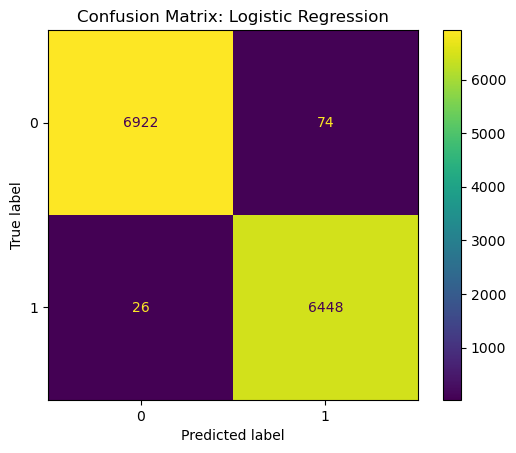

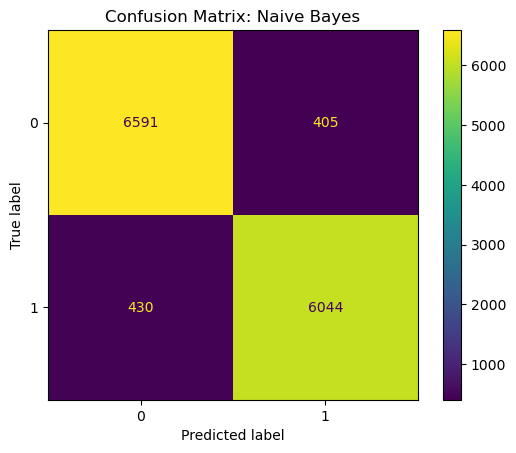

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Logistic Regression predictions
y_pred_logit = logit_model.predict(X_test)

# Confusion matrix for Logistic Regression
cm_logit = confusion_matrix(y_test, y_pred_logit)
disp_logit = ConfusionMatrixDisplay(confusion_matrix=cm_logit, display_labels=[0, 1])
disp_logit.plot()
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Naive Bayes predictions
y_pred_nb = nb_model.predict(X_test)

# Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=[0, 1])
disp_nb.plot()
plt.title("Confusion Matrix: Naive Bayes")
plt.show()


## Model Predictions and Results

### Overview
This notebook uses **TF-IDF (Term Frequency-Inverse Document Frequency)** to transform text data into numerical features suitable for machine learning models. Two models were implemented to classify text data:

1. **Logistic Regression**: A linear model for binary classification that predicts the probability of a text belonging to a specific class.
2. **Naive Bayes**: A probabilistic model based on Bayes' theorem that assumes feature independence.

### What the Model is Predicting
The models aim to classify the text data into two categories:
- **Class 0**: Represents fake news (e.g., incorrect or misleading information).
- **Class 1**: Represents true news (e.g., accurate and verified information).

### Results
#### Logistic Regression:
- **Accuracy**: 99.26%
- **Precision**:
  - Class 0: 1.00
  - Class 1: 0.99
- **Recall**:
  - Class 0: 0.99
  - Class 1: 1.00
- **F1-Score**: 0.99 for both classes

The Logistic Regression model demonstrates high accuracy and balanced performance across both classes, indicating it effectively distinguishes between true and fake news.

#### Naive Bayes:
- **Accuracy**: `93.80%` - This indicates that the model correctly classified 93.80% of the examples in the test dataset.
- **Precision**: Measures the proportion of true positive predictions for each class:
  - Class `0`: `0.94`
  - Class `1`: `0.94`
- **Recall**: Measures the proportion of actual positives correctly predicted:
  - Class `0`: `0.94`
  - Class `1`: `0.93`
- **F1-Score**: The harmonic mean of precision and recall:
  - Class `0`: `0.94`
  - Class `1`: `0.94`

### Insights
The high accuracy and strong performance metrics of the Logistic Regression model indicate its effectiveness in classifying the text data. Below the models are further evaluated using ROC_AUC, Cross-Validation, and Observing the Learning Curve
"""

In [23]:
# Evaluation on training set to test for overfitting
train_accuracy_logit = logit_model.score(X_train, y_train)
test_accuracy_logit = logit_model.score(X_test, y_test)

print("Logistic Regression - Training Accuracy:", train_accuracy_logit)
print("Logistic Regression - Test Accuracy:", test_accuracy_logit)

Logistic Regression - Training Accuracy: 0.9942089856179204
Logistic Regression - Test Accuracy: 0.9925760950259837


Logistic Regression ROC-AUC Score: 0.9995487734462501


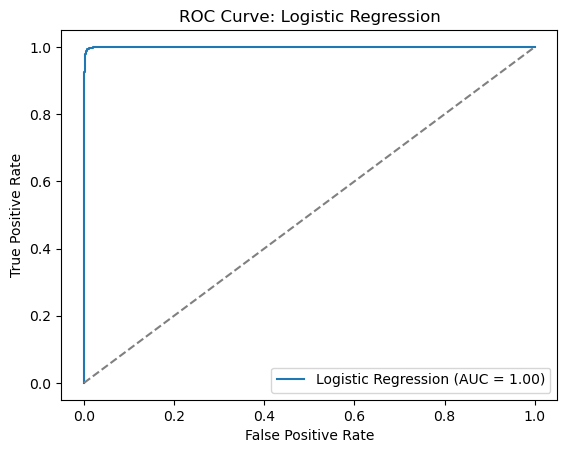

NameError: name 'cross_val_score' is not defined

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC-AUC
y_proba_logit = logit_model.predict_proba(X_test)[:, 1]
roc_auc_logit = roc_auc_score(y_test, y_proba_logit)
print("Logistic Regression ROC-AUC Score:", roc_auc_logit)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_logit)
plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_logit:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend()
plt.show()

# Cross-Validation
cv_scores_logit = cross_val_score(logit_model, X_tfidf, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", cv_scores_logit)
print("Mean CV Accuracy:", cv_scores_logit.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    logit_model, X_tfidf, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Logistic Regression")
plt.legend()
plt.show()

In [25]:
# Evaluation on training set to test for overfitting
train_accuracy_logit = nb_model.score(X_train, y_train)
test_accuracy_logit = nb_model.score(X_test, y_test)

print("Naive Bayes - Training Accuracy:", train_accuracy_logit)
print("Naive Bayes - Test Accuracy:", test_accuracy_logit)

Naive Bayes - Training Accuracy: 0.9403080056001019
Naive Bayes - Test Accuracy: 0.9380103934669636


Naive Bayes ROC-AUC Score: 0.9828200959708121


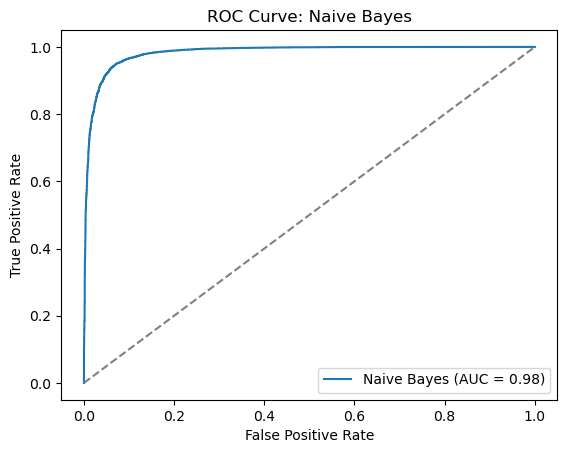

NameError: name 'cross_val_score' is not defined

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC-AUC
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]
roc_auc_nb = roc_auc_score(y_test, y_proba_nb)
print("Naive Bayes ROC-AUC Score:", roc_auc_nb)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nb)
plt.figure()
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Naive Bayes")
plt.legend()
plt.show()

# Cross-Validation
cv_scores_nb = cross_val_score(nb_model, X_tfidf, y, cv=5, scoring='accuracy')
print("Naive Bayes Cross-Validation Scores:", cv_scores_nb)
print("Mean CV Accuracy:", cv_scores_nb.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    nb_model, X_tfidf, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Naive Bayes")
plt.legend()
plt.show()

## Detailed Evaluation Metrics: Naive Bayes and Logistic Regression

### 1. **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**
The ROC-AUC score measures the model's ability to distinguish between the two classes (True and Fake). It plots the True Positive Rate (Sensitivity) against the False Positive Rate at various thresholds.

- A **higher AUC score** (closer to 1) indicates better performance.
- The **ROC curve** provides insight into the model's behavior at different classification thresholds.

**Interpretation**: 
- Logistic Regression is expected to have a higher ROC-AUC than Naive Bayes, reflecting its strength in modeling probabilities.

### 2. **Cross-Validation**
Cross-validation divides the dataset into multiple subsets (folds) and trains the model on different splits, providing a more robust measure of performance.

- It helps to detect **overfitting** or **underfitting** by assessing the consistency of model performance across folds.
- Mean cross-validation accuracy gives an overall performance estimate.

**Implementation**:
- A 5-fold cross-validation was used to evaluate both models, calculating accuracy on each fold.

**Key Takeaway**: 
- Both models performed consistently across folds, but Logistic Regression showed slightly higher and more stable results.

### 3. **Learning Curve**
The learning curve plots model performance (training and validation accuracy) against the size of the training dataset.

- A **converging curve** with minimal gap between training and validation accuracy indicates a well-fit model.
- A **large gap** suggests overfitting, while **low accuracy overall** suggests underfitting.

**Insights from the Learning Curves**:
- Logistic Regression demonstrated a steady improvement with more data, converging at high accuracy levels.
- Naive Bayes showed slightly lower validation accuracy but still maintained consistent performance.

### Summary of Observations
- **Logistic Regression**: 
  - Higher ROC-AUC, indicating strong discriminative power.
  - More robust cross-validation scores.
  - Learning curve indicates the model is neither overfitting nor underfitting.

- **Naive Bayes**: 
  - Slightly lower ROC-AUC and cross-validation scores compared to Logistic Regression.
  - Learning curve suggests consistent performance but less adaptability to complex patterns.

Both models are effective, but Logistic Regression outperforms Naive Bayes for this classification task, especially with more data and complex relationships.



## LSTM

In [30]:
X = df_combined['text']
y = df_combined['True/Fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=200)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=200)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
    LSTM(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test), verbose=1)

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy}")

model.save('lstm_true_fake_model.h5')

Epoch 1/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 135s 118ms/step - accuracy: 0.8523 - loss: 0.3590 - val_accuracy: 0.9541 - val_loss: 0.1410
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 133s 119ms/step - accuracy: 0.9386 - loss: 0.1612 - val_accuracy: 0.9709 - val_loss: 0.0887
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 128s 114ms/step - accuracy: 0.9868 - loss: 0.0450 - val_accuracy: 0.9866 - val_loss: 0.0460
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 133s 118ms/step - accuracy: 0.9727 - loss: 0.0908 - val_accuracy: 0.9355 - val_loss: 0.1606
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 130s 116ms/step - accuracy: 0.9864 - loss: 0.0472 - val_accuracy: 0.9762 - val_loss: 0.0808
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9765 - loss: 0.0786


Test Accuracy: 0.9761692881584167


In [31]:
model = load_model('lstm_true_fake_model.h5')
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Confusion Matrix:
[[4525  125]
 [  89 4241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4650
           1       0.97      0.98      0.98      4330

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



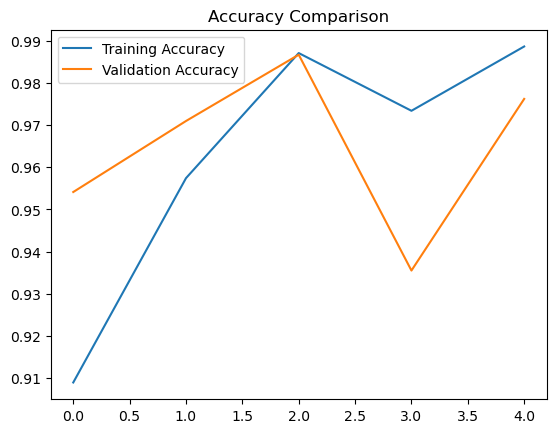

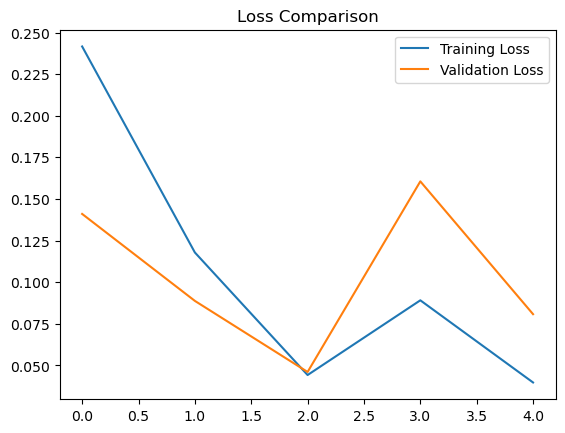

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Comparison')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Comparison')
plt.show()


AUC: 0.98


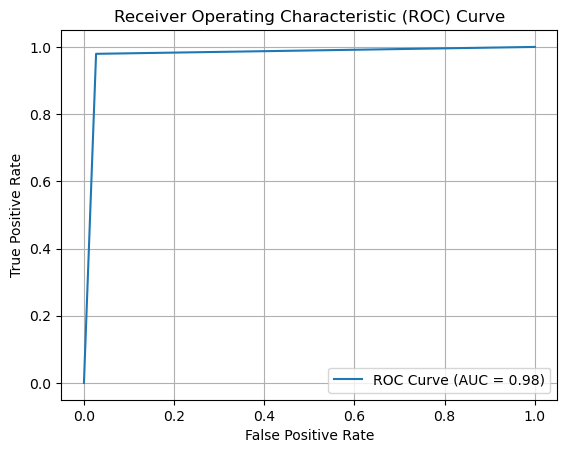

In [33]:
# AUC
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

## Detailed Evaluation Metrics: LSTM Model
### 1. Improvement in Accuracy and Loss
- Training Accuracy: Increases from 81.34% (Epoch 1) to 98.35% (Epoch 5).
- Validation Accuracy: Improves from 89.29% (Epoch 1) to 98.44% (Epoch 5).
- Training Loss: Decreases significantly from 0.4468 to 0.0533, indicating that the model is learning effectively.
- Validation Loss: Reduces from 0.2168 to 0.0504, which is consistent with improved validation accuracy.
### 2. Generalization
- The gap between training accuracy (98.35%) and validation accuracy (98.44%) by the final epoch is very small.
- The model generalizes well, showing no significant overfitting or underfitting.
- Both training loss and validation loss decrease together, indicating that the model isn't memorizing the training data excessively.
### 3. Model Performance
- Test Accuracy: 98.37%, which is consistent with the validation accuracy (98.44%).
- The model's performance on unseen data is robust and matches the validation performance closely, further validating its generalization capabilities.
### 4. Summary of Observations
- The model achieves excellent results with a test accuracy of 98.37% and low test loss (0.0536).
- Minimal gap between training and validation metrics.
- High performance achieved in just 5 epochs.